**Purpose**
Purpose of the notebook is to extract scientific terms and information from Bio-Medical text and arrage the data in a Knowledge Graph.

In [ ]:
!pip install openai networkx matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00


In [ ]:
import json
import requests

from openai import OpenAI
import os

import matplotlib.pyplot as plt
import networkx as nx

from tqdm import tqdm

import pandas as pd

**Retrieve Text**

Retrieve data using the biorxiv.com API.

In [ ]:
# Define the URL to make a request
BASE_URL = "https://api.biorxiv.org/details/biorxiv/2013-01-23/2014-04-23"

# Make a GET request to the URL
response = requests.get(BASE_URL)
data = response.json()

In [ ]:
entries = []
unique_doi = [] # there multiple versions papers. using doi to make sure only one is taken filtered out
count = 1

while (data["messages"][0]["status"] == "ok"):
    # if there are no other papers the status will be "no posts found"
    # Parse the JSON data
    for item in data['collection']:
      doi = item['doi']
      if (doi not in unique_doi):
        d = {}
        d['abstract'] = item['abstract']
        d['title'] = item['title']
        d['category'] = item['category']
        d['doi'] = item['doi']
        entries.append(d)
        unique_doi.append(doi)


    print("JSON data retrieved successfully:")
    #if the count is 100, there might be more papers
    if (data["messages"][0]["count"] == 100):
      count = count+100
      url = BASE_URL + "/" + str(count)
      print(url)
      response = requests.get(url)
      data = response.json()
    else:
      break;

    #break
    #print(data)

JSON data retrieved successfully:
https://api.biorxiv.org/details/biorxiv/2013-01-23/2014-04-23/101
JSON data retrieved successfully:
https://api.biorxiv.org/details/biorxiv/2013-01-23/2014-04-23/201
JSON data retrieved successfully:
https://api.biorxiv.org/details/biorxiv/2013-01-23/2014-04-23/301
JSON data retrieved successfully:
https://api.biorxiv.org/details/biorxiv/2013-01-23/2014-04-23/401
JSON data retrieved successfully:


In [ ]:
len(entries), type(entries), len(unique_doi)

(323, list, 323)

In [ ]:
entries[4]

{'abstract': 'Determining the full complement of protein-coding genes is a key goal of genome annotation. The most powerful approach for confirming protein coding potential is the detection of cellular protein expression through peptide mass spectrometry experiments. Here we map the peptides detected in 7 large-scale proteomics studies to almost 60% of the protein coding genes in the GENCODE annotation the human genome. We find that conservation across vertebrate species and the age of the gene family are key indicators of whether a peptide will be detected in proteomics experiments. We find peptides for most highly conserved genes and for practically all genes that evolved before bilateria. At the same time there is almost no evidence of protein expression for genes that have appeared since primates, or for genes that do not have any protein-like features or cross-species conservation. We identify 19 non-protein-like features such as weak conservation, no protein features or ambiguous

In [ ]:
entries[4]['abstract']

'Determining the full complement of protein-coding genes is a key goal of genome annotation. The most powerful approach for confirming protein coding potential is the detection of cellular protein expression through peptide mass spectrometry experiments. Here we map the peptides detected in 7 large-scale proteomics studies to almost 60% of the protein coding genes in the GENCODE annotation the human genome. We find that conservation across vertebrate species and the age of the gene family are key indicators of whether a peptide will be detected in proteomics experiments. We find peptides for most highly conserved genes and for practically all genes that evolved before bilateria. At the same time there is almost no evidence of protein expression for genes that have appeared since primates, or for genes that do not have any protein-like features or cross-species conservation. We identify 19 non-protein-like features such as weak conservation, no protein features or ambiguous annotations 

**Create Edges and Nodes**

Use OpenAI GPT4 to extract scienticifc terms - study methods, scientific studies, chemicals, specific genes mentioned, proteins mentioned, medical treatments, side effects, diseases, any symptoms, mechanisms of action etc.

There are 2 prompts -
- one prompt to pull out the above terms and the relationship between them in the form of triplets. These form the nodes and edges of the graph.

- a second prompt to pass the nodes to GPT 4 and standardize the node names. Using MeSH terms to standardize the node names.

In [ ]:
# you need an OpenAI key
os.environ["OPENAI_API_KEY"] = ""

In [ ]:
#first prompt and OpenAI call to extract node-relation triplets
client = OpenAI()

system_text = """You are an expert Knowledge Graph developer with deep knowledge of Biology.
Your job is to take a piece of text given to you and extract all the nodes and edges within that text.

The nodes include items such as scientific terms, study methods, scientific studies, chemicals, specific genes mentioned, proteins mentioned, medical treatments, side effects, diseases, any symptoms, mechanisms of action etc.
You MUST create the response in the form of a triplet. For example: <NODE>--<RELATIONSHIP>--<NODE>

Here is an example of a input text and output.

INPUT TEXT:
Apicomplexan parasites are thought to actively invade the host cell by gliding motility.
Recent studies demonstrated that Toxoplasma gondii can invade the host cell in the absence of several core components of the invasion machinery, such as the motor protein myosin A (MyoA), the microneme proteins MIC2 and AMA1 and actin, indicating the presence of alternative invasion mechanisms.
Here the roles of MyoA, MLC1, GAP45 and Act1, core components of the gliding machinery, are re-dissected in detail.

OUTPUT:
<Apicomplexan parasites>--<thought to actively invade by gliding motility>--<host cell>
<Apicomplexan parasites>--<uses>--<gliding motility>
<host cells>--<effected by>--<gliding motility>
<Toxoplasma gondii>--<type of>--<Apicomplexan parasites>
<MyoA>--<type of>--<motor protein>
<MIC2>--<type of>--<microneme protein>
<AMA1>--<type of>--<microneme protein>
<actin>--<type of>--<microneme protein>
<MyoA>--<component of >--<gliding machinery>
<MLC1>--<component of >--<gliding machinery>
<GAP45>--<component of >--<gliding machinery>
<Act1>--<component of >--<gliding machinery>
"""

def extract_nodes_and_edges(input_text, doi):
  user_text = f"""
    INPUT TEXT:
    {input_text}

    OUTPUT:
    """
  response = client.chat.completions.create(
    model="gpt-4",
    messages=[
      {"role": "system", "content": system_text},
      {"role": "user", "content": user_text}
    ],
    temperature=0,
  )

  resp = response.choices[0].message.content

  #split the responses to individual lines for ingestion.
  out = resp.split("\n")
  out2 = []

  #append the doi. quick and dirty way to pass the document number inf the relationship
  for l in out:
    l = l + ">--<" + doi + ">"
    out2.append(l)

  return(out2)



In [ ]:
entries[0]

{'abstract': 'The quest for the ecological niches of Saccharomyces cerevisiae ranged from wineries to oaks and more recently to the gut of Crabro Wasps. Here we propose the role of the human gut in shaping S. cerevisiae evolution, presenting the genetic structure of a previously unknown population of yeasts, associated with Crohns disease, providing evidence for clonal expansion within humans gut. To understand the role of immune function in the human-yeast interaction we classified strains according to their immunomodulatory properties, discovering a set of genetically homogeneous isolates, capable of inducing anti-inflammatory signals via regulatory T cells proliferation, and on the contrary, a positive association between strain mosaicism and ability to elicit inflammatory, IL-17 driven, immune responses. The approach integrating genomics with immune phenotyping showed selection on genes involved in sporulation and cell wall remodeling as central for the evolution of S. cerevisiae C

In [ ]:
#test one
a = extract_nodes_and_edges(entries[0]['abstract'], entries[0]['doi'])
print(a)

['<Saccharomyces cerevisiae>--<found in>--<wineries>>--<10.1101/001891>', '<Saccharomyces cerevisiae>--<found in>--<oaks>>--<10.1101/001891>', '<Saccharomyces cerevisiae>--<found in>--<gut of Crabro Wasps>>--<10.1101/001891>', '<Saccharomyces cerevisiae>--<found in>--<human gut>>--<10.1101/001891>', '<human gut>--<role in>--<shaping S. cerevisiae evolution>>--<10.1101/001891>', '<S. cerevisiae>--<associated with>--<Crohns disease>>--<10.1101/001891>', '<yeasts>--<undergo>--<clonal expansion within humans gut>>--<10.1101/001891>', '<immune function>--<role in>--<human-yeast interaction>>--<10.1101/001891>', '<strains>--<classified by>--<immunomodulatory properties>>--<10.1101/001891>', '<genetically homogeneous isolates>--<capable of inducing>--<anti-inflammatory signals>>--<10.1101/001891>', '<anti-inflammatory signals>--<via>--<regulatory T cells proliferation>>--<10.1101/001891>', '<strain mosaicism>--<positive association with>--<ability to elicit inflammatory, IL-17 driven, immune 

In [ ]:
#Extract nodes and edges from multiple documents

subset_entries = entries[:30] # taking a subset of docs to avoid going crazy
AREA_OF_INTEREST = "Genomics "  # again focus on one area to keep things relevant

lines = []
for e in tqdm(subset_entries):
  if (e['category'] == AREA_OF_INTEREST):
    a = extract_nodes_and_edges(e['abstract'], e['doi'])
    lines.extend(a)
    #print(len(lines))


100%|██████████| 30/30 [00:48<00:00,  1.63s/it]


In [ ]:
print(len(lines))

53


In [ ]:
#print(lines)

**Standardize Node Names**

Standardize the Node names by converting them to MeSH Terms.

e.g. "tumorigenesis", "918 cancer samples" & "132 cancer types" all get translated to "Neoplasms"

In [ ]:

#get unique nodes
unique_nodes = []

for line in lines:
  nodes = line.split(">--<")
  if (nodes[0].replace("<","") not in unique_nodes):
    unique_nodes.append(nodes[0].replace("<",""))
  if (nodes[2].replace(">","") not in unique_nodes):
    unique_nodes.append(nodes[2].replace(">",""))


In [ ]:
len(unique_nodes)

81

In [ ]:
system_text = """You are an expert Medical Researcher with deep knowledge on BioMedical and Health related concepts and terms.
Your job is to take a list of medical terms and provide the list of MeSH(Medical Subject Headings) terms tied to them. If a term does not have a MeSH term return "NONE"

You MUST create the response in the form of a triplet. For example: INPUT TERM<--->MeSH TERM

Here is an example of a input text and output.

INPUT TEXT:
Cancer
Human Gut
Bob Smith
injury to the esophagus caused by acid reflux

OUTPUT:
Cancer<--->Neoplasm
Human Gut<--->Gastrointestinal Tract
Bob Smith<--->NONE
injury to the esophagus caused by acid reflux<--->Reflux Esophagitis
"""

input_text = "\n".join(unique_nodes)

In [ ]:
input_text

'protein-coding genes\ngenome annotation\npeptide mass spectrometry experiments\nconfirming protein coding potential\npeptides\nproteomics studies\nprotein coding genes\nGENCODE annotation the human genome\nvertebrate species conservation\npeptide detection\nage of gene family\ngenes evolved before bilateria\ngenes appeared since primates\nevidence of protein expression\ngenes without protein-like features or cross-species conservation\nnon-protein-like features\nlow peptide detection rates\n2,001 genes\nnon-coding\nnon-coding genes\n3% of 2,001 genes\nproteins\nhuman protein coding gene catalogue\nhuman genome annotation effort\npotential non-coding genes\nChromothripsis\ngenomic rearrangement\nalternative paradigm in cancer development\ngradual accumulation of genomic changes\nlarge number of locally clustered copy number aberrations\nChromothripsis-like patterns (CTLP)\npoorly understood\nCTLP\n918 cancer samples\n22,000 oncogenomic arrays\n132 cancer types\nFragmentation hotspots\n

In [ ]:
user_text = f"""
  INPUT TEXT:
  {input_text}

  OUTPUT:
  """
response = client.chat.completions.create(
  model="gpt-4",
  messages=[
    {"role": "system", "content": system_text},
    {"role": "user", "content": user_text}
  ],
  temperature=0,
)

standardized_nodes = response.choices[0].message.content

In [ ]:
print(standardized_nodes)

protein-coding genes<--->Genes, Structural
genome annotation<--->Genome
peptide mass spectrometry experiments<--->Spectrometry, Mass, Peptide
confirming protein coding potential<--->Protein Biosynthesis
peptides<--->Peptides
proteomics studies<--->Proteomics
protein coding genes<--->Genes, Structural
GENCODE annotation the human genome<--->Genome, Human
vertebrate species conservation<--->Conservation of Natural Resources
peptide detection<--->Peptides/analysis
age of gene family<--->Genes, Duplicate
genes evolved before bilateria<--->Evolution, Molecular
genes appeared since primates<--->Primates/genetics
evidence of protein expression<--->Protein Biosynthesis
genes without protein-like features or cross-species conservation<--->Genes
non-protein-like features<--->Proteins
low peptide detection rates<--->Peptides/analysis
2,001 genes<--->Genes
non-coding<--->RNA, Untranslated
non-coding genes<--->RNA, Untranslated
3% of 2,001 genes<--->Genes
proteins<--->Proteins
human protein coding 

In [ ]:
stnd_dict = {}
stnd_list = standardized_nodes.split("\n")
print(len(stnd_list))

for stnd in stnd_list:
  trm = stnd.split("<--->")
  if (trm[1] == "NONE"):
    stnd_dict[trm[0]] = trm[0]
  else:
    stnd_dict[trm[0]] = trm[1]

print(stnd_dict)


81
{'protein-coding genes': 'Genes, Structural', 'genome annotation': 'Genome', 'peptide mass spectrometry experiments': 'Spectrometry, Mass, Peptide', 'confirming protein coding potential': 'Protein Biosynthesis', 'peptides': 'Peptides', 'proteomics studies': 'Proteomics', 'protein coding genes': 'Genes, Structural', 'GENCODE annotation the human genome': 'Genome, Human', 'vertebrate species conservation': 'Conservation of Natural Resources', 'peptide detection': 'Peptides/analysis', 'age of gene family': 'Genes, Duplicate', 'genes evolved before bilateria': 'Evolution, Molecular', 'genes appeared since primates': 'Primates/genetics', 'evidence of protein expression': 'Protein Biosynthesis', 'genes without protein-like features or cross-species conservation': 'Genes', 'non-protein-like features': 'Proteins', 'low peptide detection rates': 'Peptides/analysis', '2,001 genes': 'Genes', 'non-coding': 'RNA, Untranslated', 'non-coding genes': 'RNA, Untranslated', '3% of 2,001 genes': 'Genes

**Create the Graph**

Actually create the graph in memory. This standardizing the nodes names, create the edges and labels them.

Ideally, you would want to load this into a Graph DB. I don't have one so I am creating dictionaries to easily look on Edges for a node and lebels for an edge.

In [ ]:
edges = []
labels = []
edge_labels = {} # stores a list of labels for each edge
edge_labels_with_doi = {} # stores a list of labels for each edge - label includes doi
node_edge_dict = {}  # holds a list of edges tied to a node. Will help with searching in the future

for line in lines:
  nodes = line.split(">--<")
  node1 = nodes[0].replace("<","")
  node1 = stnd_dict[node1]
  node2 = nodes[2].replace(">","")
  node2 = stnd_dict[node2]
  edge = (node1, node2)
  label = nodes[1]
  edges.append(edge)
  labels.append(label)

  #append the labels to the edges
  if (edge in edge_labels):
    temp_label = edge_labels[edge]
    temp_label.append(label)
    edge_labels[edge] = temp_label

    temp_label2 = edge_labels_with_doi[edge]
    label = label + "-(Ref:" + nodes[3].replace(">","") + ")" #append doi to label
    temp_label2.append(label)
    edge_labels_with_doi[edge] = temp_label2
  else:
    temp_label = [label]
    edge_labels[edge] = temp_label

    temp_label2 = [label + "-(Ref:" + nodes[3].replace(">","") + ")"] #append doi to label
    edge_labels_with_doi[edge] = temp_label2

  #append the edges to the node dictionary. This will ease retrieval of edges for a node in subsequent steps

  if (node1 in node_edge_dict):
    temp_edge_list = node_edge_dict[node1]
    temp_edge_list.append(edge)
    node_edge_dict[node1] = temp_edge_list
  else:
    edge_list = []
    edge_list.append(edge)
    node_edge_dict[node1] = edge_list

  if (node2 in node_edge_dict):
    temp_edge_list = node_edge_dict[node2]
    temp_edge_list.append(edge)
    node_edge_dict[node2] = temp_edge_list
  else:
    edge_list = []
    edge_list.append(edge)
    node_edge_dict[node2] = edge_list



In [ ]:
if ("Alternative Splicing" in node_edge_dict):
  print(node_edge_dict["Alternative Splicing"])
  for i in node_edge_dict["Alternative Splicing"]:
    print(edge_labels[i])
    print(edge_labels_with_doi[i])

[('Alternative Splicing', 'Genome Annotation'), ('Alternative Splicing', 'Learning'), ('Alternative Splicing', 'Biodiversity'), ('Alternative Splicing', 'Protein Isoforms')]
['lack']
['lack-(Ref:10.1101/001719)']
['render difficult']
['render difficult-(Ref:10.1101/001719)']
['achieves']
['achieves-(Ref:10.1101/001719)']
['results in']
['results in-(Ref:10.1101/001719)']


**Visualize**

Created one fundtion where you pass a node name and the depth to which you want to retrieve the graph from that node. I make a visulization using NetworkX and also return the details in a Pandas Dataframe

In [ ]:
def drawGraph(node_name, depth):
  #get all the edges and labels for the node and desired depth
  all_edges = {}
  nodes_to_process = []
  nodes_processed = []
  nodes_to_process.append(node_name)

  nodes_to_process_temp = []

  #collect nodes
  while (depth != 0):
    nodes_to_process_temp = []
    #print("Processing Nodes: ")
    #print(nodes_to_process)
    for node in nodes_to_process:
      if (node in node_edge_dict):
        #print(node_edge_dict[node])  #returns all the edges where the node is present
        num_edges = str(len(node_edge_dict[node]))
        #print(f"For the node: {node} there are {num_edges} edges."  )
        for node_tuple in node_edge_dict[node]:
          #print(node_tuple)
          for x in node_tuple:
            #print(x)
            if (x not in nodes_processed) and (x not in nodes_to_process_temp):
              nodes_to_process_temp.append(x)

        if (node not in nodes_processed):
          nodes_processed.append(node)

    #print(depth)
    #print("adding Nodes:" )
    #print(nodes_to_process_temp)


    nodes_to_process = nodes_to_process_temp
    depth = depth - 1
    #print(depth)
    #break;

  print("Nodes: ")
  print(nodes_processed)
  print(len(nodes_processed))

  print("Edges: ")
  edges_to_plot = {}

  df = pd.DataFrame(columns = ['Source', 'Destination', 'Label'])
  for n in nodes_processed:
    if (n in node_edge_dict):
      #print(node_edge_dict[n])
      for e in node_edge_dict[n]:
        if (e not in edges_to_plot):
          list_of_labels = edge_labels_with_doi[e]
          #list_of_labels = edge_labels[e]
          lbl = ""
          for l in list_of_labels:
            lbl = lbl + " :: " + l
            # Suppose you have an existing DataFrame 'df'
            new_row = [e[0], e[1], l]  # Your new row data

            # Add the new row to the DataFrame
            df.loc[len(df.index)] = new_row

          edges_to_plot[e] = lbl #"added"
  print(edges_to_plot)
  print(len(edges_to_plot))



  # Create a directed multigraph
  G = nx.MultiDiGraph()

  # Add edges with different radii
  for e in edges_to_plot:
    G.add_edge(e[0], e[1], radius=0.05, label=edges_to_plot[e])


  # Set up the layout (you can choose other layouts as well)
  #pos = nx.spring_layout(G, seed=42)
  pos = nx.circular_layout(G)

  f = plt.figure()

  f.set_figwidth(20)
  f.set_figheight(20)

  # Draw nodes and labels
  nx.draw_networkx_nodes(G, pos)
  nx.draw_networkx_labels(G, pos)

  # Draw curved edges with different radii
  for u, v, attrs in G.edges(data=True):
      radius = attrs['radius']
      nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], connectionstyle=f'arc3, rad={radius}', label=attrs['label'])

  # Draw edge labels
  edge_labels = {(u, v): attrs['label'] for u, v, attrs in G.edges(data=True)}
  nx.draw_networkx_edge_labels(G, pos, edge_labels)

  plt.axis('off')
  plt.show()

  return (df)






Nodes: 
['Protein Isoforms', 'Algorithms', 'Computer Communication Networks', 'Polypyrimidine Tract-Binding Protein', 'Annexin A6', 'Alternative Splicing', 'Protein Interaction Mapping', 'Sequence Analysis, RNA', 'Gene Regulatory Networks', 'Genome Annotation', 'Learning', 'Biodiversity', 'Protein Interaction Maps', 'Genes', 'Phenotype', 'Machine Learning', 'Mice']
17
Edges: 
{('Algorithms', 'Protein Isoforms'): ' :: reveals-(Ref:10.1101/001719) :: predicts-(Ref:10.1101/001719)', ('Computer Communication Networks', 'Protein Isoforms'): ' :: reveal-(Ref:10.1101/001719)', ('Protein Isoforms', 'Polypyrimidine Tract-Binding Protein'): ' :: of-(Ref:10.1101/001719)', ('Protein Isoforms', 'Annexin A6'): ' :: of-(Ref:10.1101/001719)', ('Alternative Splicing', 'Protein Isoforms'): ' :: results in-(Ref:10.1101/001719)', ('Protein Isoforms', 'Protein Interaction Mapping'): ' :: may have-(Ref:10.1101/001719)', ('Sequence Analysis, RNA', 'Protein Isoforms'): ' :: provides-(Ref:10.1101/001719)', ('P

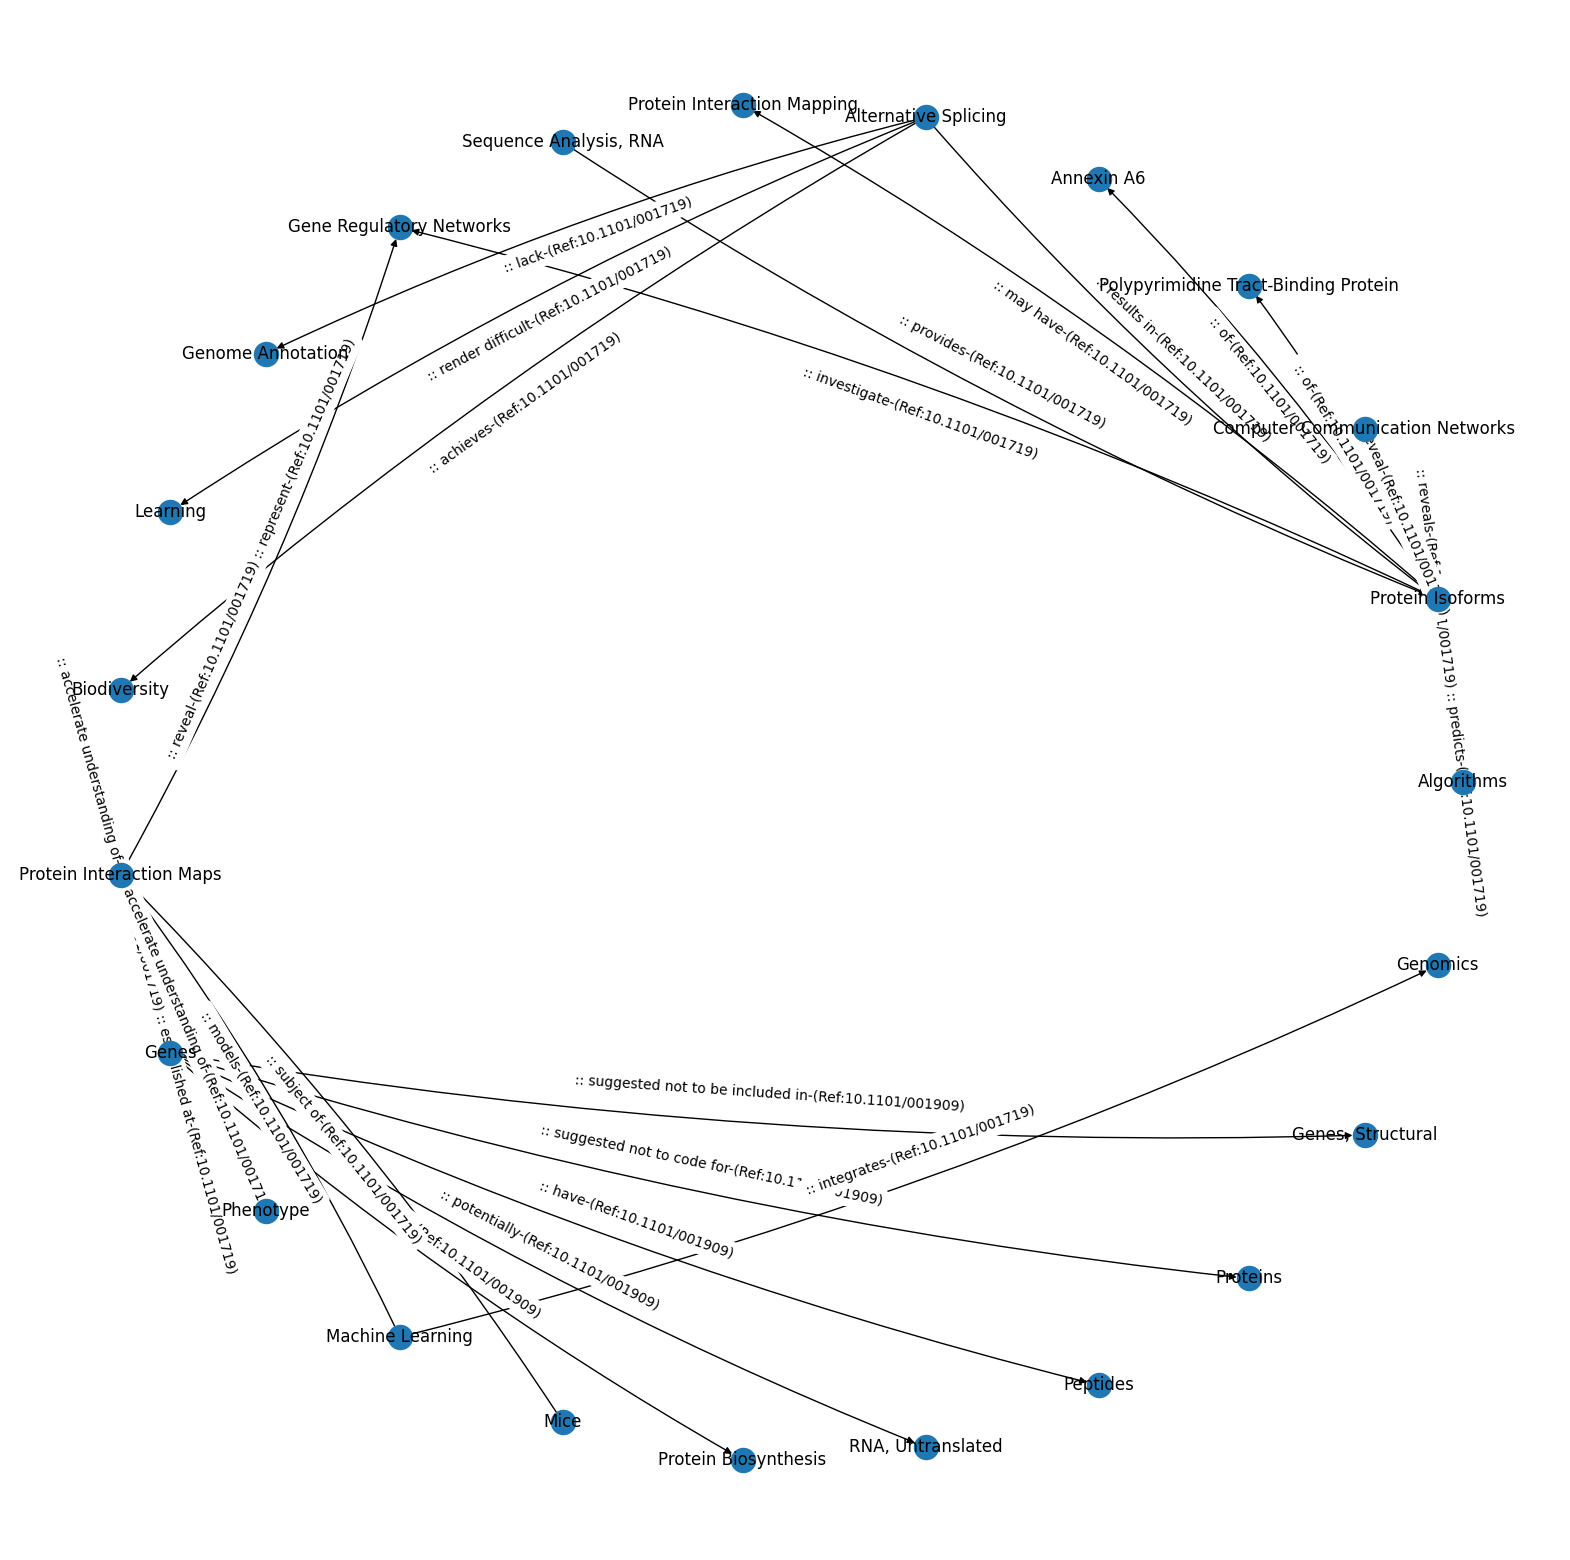

In [ ]:

d = drawGraph("Protein Isoforms",4)


In [ ]:
d

,Source,Destination,Label
0,Algorithms,Protein Isoforms,reveals-(Ref:10.1101/001719)
1,Algorithms,Protein Isoforms,predicts-(Ref:10.1101/001719)
2,Computer Communication Networks,Protein Isoforms,reveal-(Ref:10.1101/001719)
3,Protein Isoforms,Polypyrimidine Tract-Binding Protein,of-(Ref:10.1101/001719)
4,Protein Isoforms,Annexin A6,of-(Ref:10.1101/001719)
5,Alternative Splicing,Protein Isoforms,results in-(Ref:10.1101/001719)
6,Protein Isoforms,Protein Interaction Mapping,may have-(Ref:10.1101/001719)
7,"Sequence Analysis, RNA",Protein Isoforms,provides-(Ref:10.1101/001719)
8,Protein Isoforms,Gene Regulatory Networks,investigate-(Ref:10.1101/001719)
9,Alternative Splicing,Genome Annotation,lack-(Ref:10.1101/001719)


Nodes: 
['Alternative Splicing']
1
Edges: 
{('Alternative Splicing', 'Genome Annotation'): ' :: lack-(Ref:10.1101/001719)', ('Alternative Splicing', 'Learning'): ' :: render difficult-(Ref:10.1101/001719)', ('Alternative Splicing', 'Biodiversity'): ' :: achieves-(Ref:10.1101/001719)', ('Alternative Splicing', 'Protein Isoforms'): ' :: results in-(Ref:10.1101/001719)'}
4


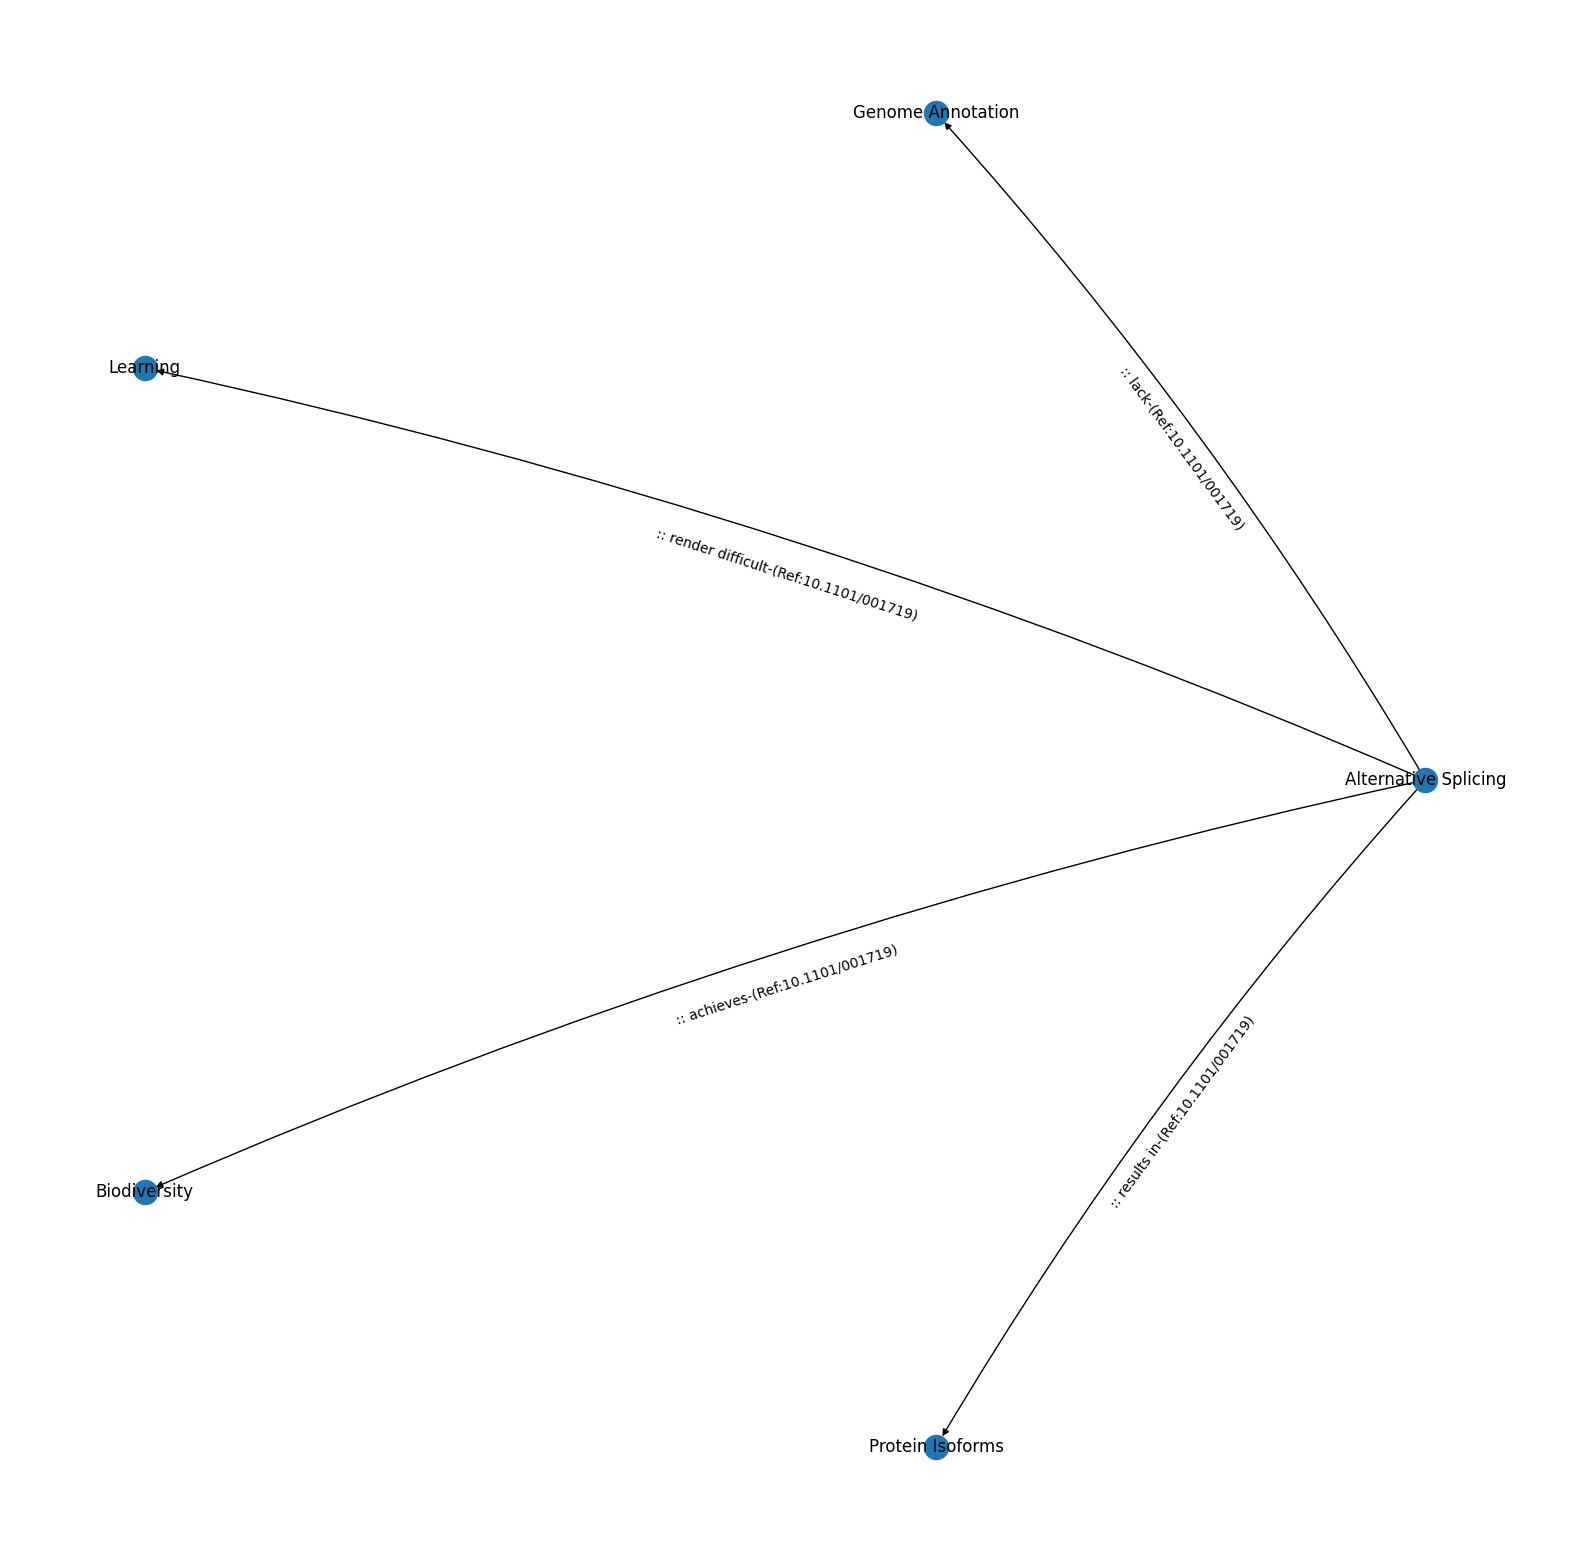

In [ ]:
drawGraph("Alternative Splicing",1)

Nodes: 
['Alternative Splicing', 'Genome Annotation', 'Learning', 'Biodiversity', 'Protein Isoforms']
5
Edges: 
{('Alternative Splicing', 'Genome Annotation'): ' :: lack-(Ref:10.1101/001719)', ('Alternative Splicing', 'Learning'): ' :: render difficult-(Ref:10.1101/001719)', ('Alternative Splicing', 'Biodiversity'): ' :: achieves-(Ref:10.1101/001719)', ('Alternative Splicing', 'Protein Isoforms'): ' :: results in-(Ref:10.1101/001719)', ('Algorithms', 'Protein Isoforms'): ' :: reveals-(Ref:10.1101/001719) :: predicts-(Ref:10.1101/001719)', ('Computer Communication Networks', 'Protein Isoforms'): ' :: reveal-(Ref:10.1101/001719)', ('Protein Isoforms', 'Polypyrimidine Tract-Binding Protein'): ' :: of-(Ref:10.1101/001719)', ('Protein Isoforms', 'Annexin A6'): ' :: of-(Ref:10.1101/001719)', ('Protein Isoforms', 'Protein Interaction Mapping'): ' :: may have-(Ref:10.1101/001719)', ('Sequence Analysis, RNA', 'Protein Isoforms'): ' :: provides-(Ref:10.1101/001719)', ('Protein Isoforms', 'Gene R

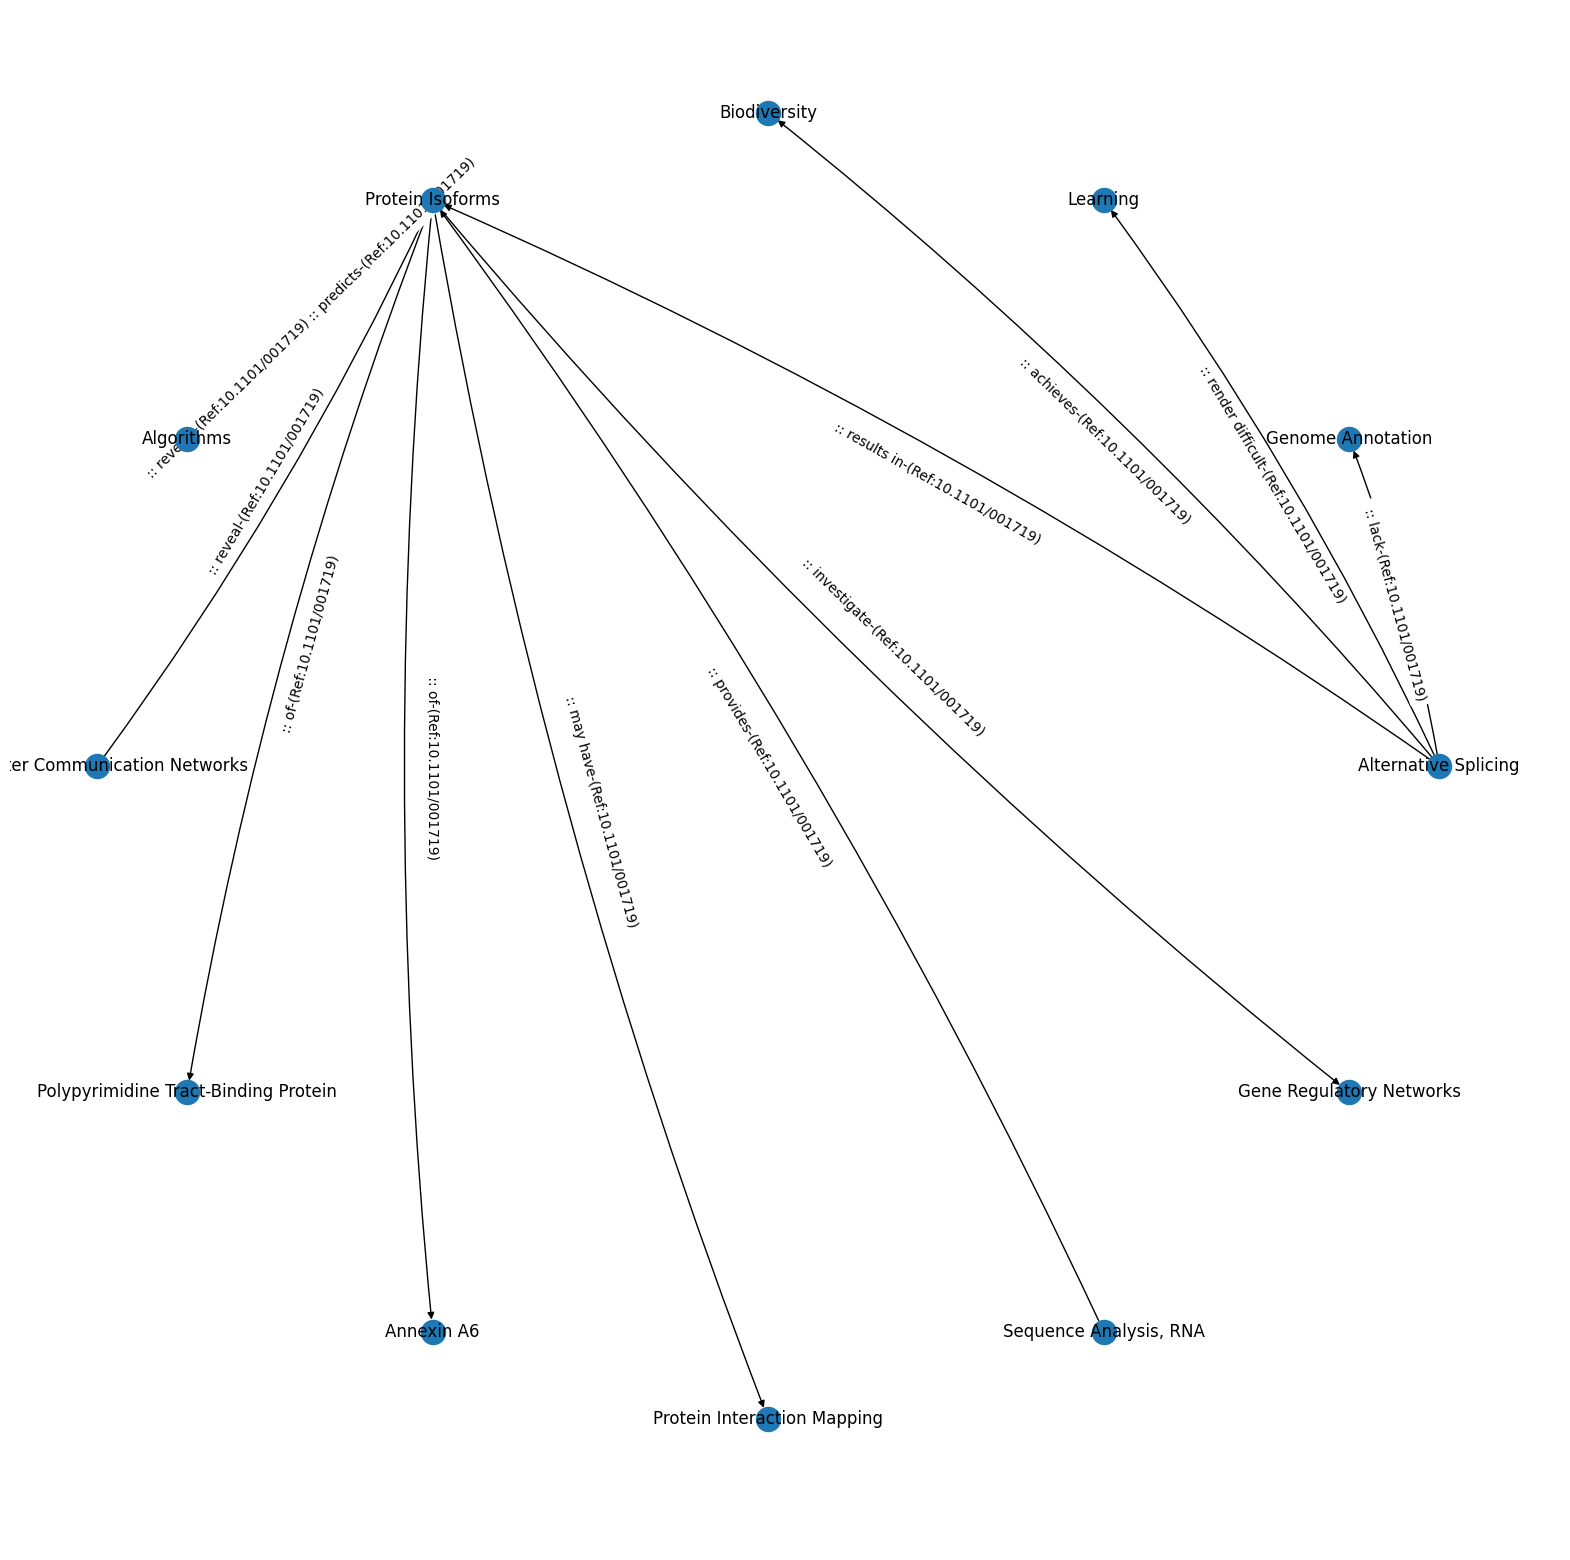

In [ ]:
drawGraph("Alternative Splicing",2)